### 5.2.8 Model CatBoost (handle missing value and categorical variables)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

from tabulate import tabulate
%matplotlib inline

In [2]:

print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [5]:
df.shape

(18359, 14)

In [6]:
X = df.drop(['target','enrollee_id'],axis=1)
y = df['target']

In [7]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [8]:
for i in cat_features:
    X[i].fillna('N/A', inplace =True)

In [9]:
X[cat_features].isnull().sum()

city                   0
gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

In [10]:
cat_featurelist = []
cat_features
for i, j in enumerate(X.columns):
    if j in cat_features:
        cat_featurelist.append(i)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X.to_numpy(), y.ravel(), test_size=0.30, stratify=y, random_state=43)

In [12]:
y_test.sum()

728

In [13]:
def trainmodel_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        model.fit(X_train_fold, y_train_fold, cat_features = cat_featurelist, verbose=10)
    
    return model

In [14]:
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

Learning rate set to 0.5
0:	learn: 0.4848328	total: 59.6ms	remaining: 238ms
4:	learn: 0.3714210	total: 84.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 4.95ms	remaining: 19.8ms
4:	learn: 0.3744055	total: 27.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 5.61ms	remaining: 22.5ms
4:	learn: 0.3743519	total: 29ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 4.58ms	remaining: 18.3ms
4:	learn: 0.3728718	total: 26.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 4.72ms	remaining: 18.9ms
4:	learn: 0.3750948	total: 25.3ms	remaining: 0us


,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.0,0.0,0.0,0.669,650.0,1198.0


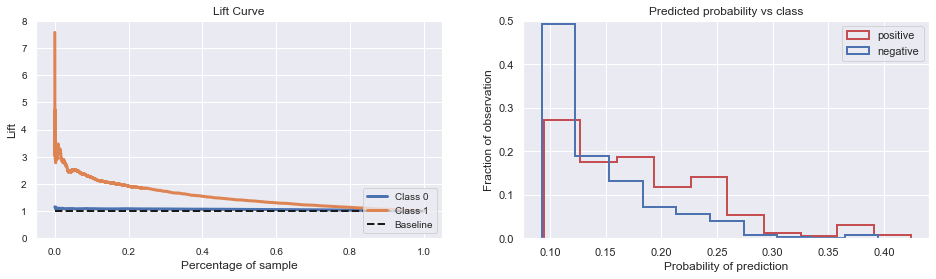

In [15]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(iterations=5,random_seed=43), 'CatB', 5, X_train, y_train, 8, 0.5)

Learning rate set to 0.5
0:	learn: 0.4848328	total: 6.12ms	remaining: 24.5ms
4:	learn: 0.3714210	total: 29.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 4.53ms	remaining: 18.1ms
4:	learn: 0.3744055	total: 24.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 5.6ms	remaining: 22.4ms
4:	learn: 0.3743519	total: 49.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 4.4ms	remaining: 17.6ms
4:	learn: 0.3728718	total: 25.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 6.2ms	remaining: 24.8ms
4:	learn: 0.3750948	total: 29.9ms	remaining: 0us


,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.0,0.0,0.0,0.649,267.0,507.0


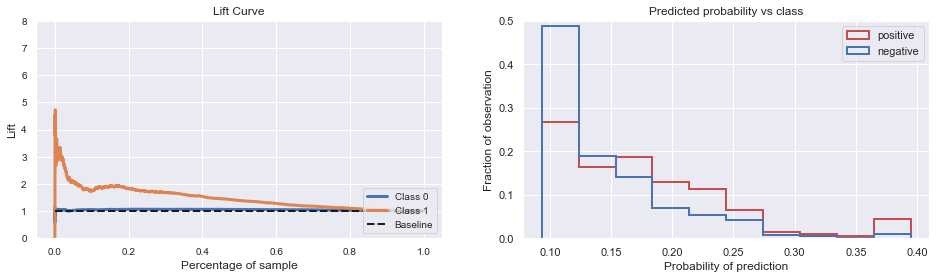

In [16]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(iterations=5,random_seed=43), 'CatB', 5, X_test, y_test, 8, 0.5)

In [17]:
def model_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    
    predProba_label = pd.DataFrame()
    #predProba_label['proba'] =(yfinal_proba - yfinal_proba.min())/(yfinal_proba.max() - yfinal_proba.min())
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3).positive_in_top20pct
    

In [18]:
[model_score(trainmodel_cv, CatBoostClassifier(iterations=i,random_seed=43), 'CatB', 5, X_test, y_test, 8, 0.5) for i in range(1,51)]

Learning rate set to 0.5
0:	learn: 0.4848328	total: 7.32ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 9.76ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 5.54ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 7.06ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 6.13ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4848328	total: 8.08ms	remaining: 8.08ms
1:	learn: 0.4173310	total: 15.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4864378	total: 6.13ms	remaining: 6.13ms
1:	learn: 0.4208651	total: 11.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4850356	total: 5.61ms	remaining: 5.61ms
1:	learn: 0.4188751	total: 10.9ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4828942	total: 4.6ms	remaining: 4.6ms
1:	learn: 0.4162073	total: 11ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.4867751	total: 6.39ms	remaining: 6.39ms
1:	learn: 0.4215361	total: 11.5ms	remaining: 0us
Lear

[CatB    246.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    236.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    250.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    267.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    267.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    269.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    271.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    275.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    268.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    280.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    265.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    265.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    270.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    273.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    271.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    270.0
 Name: positive_in_top20pct, dtype: float64,
 CatB    274.0
 Name: positive_in_top20p

Learning rate set to 0.499073
0:	learn: 0.4851011	total: 12.5ms	remaining: 523ms
10:	learn: 0.3626827	total: 86.4ms	remaining: 251ms
20:	learn: 0.3552848	total: 146ms	remaining: 153ms
30:	learn: 0.3505471	total: 210ms	remaining: 81.2ms
40:	learn: 0.3457301	total: 271ms	remaining: 13.2ms
42:	learn: 0.3449926	total: 283ms	remaining: 0us
Learning rate set to 0.499094
0:	learn: 0.4866976	total: 4.75ms	remaining: 199ms
10:	learn: 0.3671503	total: 60.7ms	remaining: 177ms
20:	learn: 0.3590669	total: 129ms	remaining: 135ms
30:	learn: 0.3547538	total: 192ms	remaining: 74.4ms
40:	learn: 0.3496132	total: 254ms	remaining: 12.4ms
42:	learn: 0.3490468	total: 266ms	remaining: 0us
Learning rate set to 0.499094
0:	learn: 0.4852972	total: 4.87ms	remaining: 204ms
10:	learn: 0.3663734	total: 66.1ms	remaining: 192ms
20:	learn: 0.3608843	total: 122ms	remaining: 128ms
30:	learn: 0.3563493	total: 183ms	remaining: 70.8ms
40:	learn: 0.3490606	total: 245ms	remaining: 11.9ms
42:	learn: 0.3479688	total: 256ms	rema

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.353,0.008,0.016,0.657,284.0,508.0


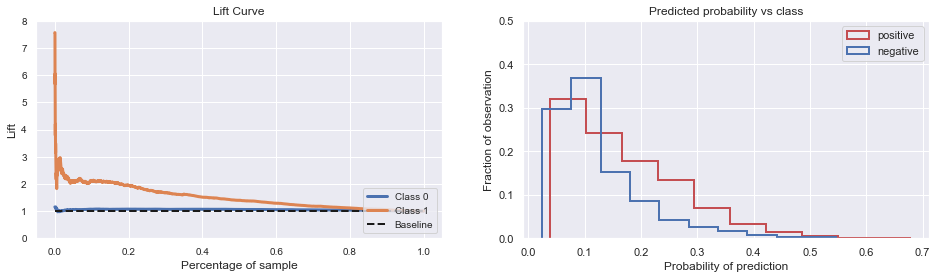

In [19]:
# as iterations = 43 gives us the best positive_in_top20pct 
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(iterations=43,random_seed=43), 'CatB', 5, X_test, y_test, 8, 0.5)